# Imports

In [1]:
import copy
import glob
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import matplotlib.image as mpimg
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
from py2tex import py2tex

In [6]:
import trove
import trove.config_parser

# Load Data

In [7]:
pm = {}

In [8]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
    global_variation = 'relative_to_accretion',
    **pm
)
cp = pm['config_parser']

In [9]:
variations = cp.execute['variations']

In [10]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [11]:
base_processed_data_dir = pm['config_parser'].get( 'DEFAULT', 'processed_data_dir' )
default_data_fp = os.path.join( base_processed_data_dir, 'summary.hdf5' )
default_data = verdict.Dict.from_hdf5( default_data_fp, create_nonexistent=True )

In [12]:
h_param = .702

## Halo Quantities

In [13]:
mvir = verdict.Dict({})
mstar = verdict.Dict({})
vc = verdict.Dict({})
rstar = verdict.Dict({})
rvir = verdict.Dict({})
for key in tqdm.tqdm( cp.variations ):
    
    # Load from summary data if available
    all_data_types_in_summary_data = True
    for data_type in [ 'Mvir', 'Mstar', 'Vc', 'Rstar0.5', 'Rvir' ]:
        if data_type not in data:
            data[data_type] = {}
        all_data_types_in_summary_data = all_data_types_in_summary_data & ( key in data[data_type] )
    if all_data_types_in_summary_data:
        mvir[key] = data['Mvir'][key]
        mstar[key] = data['Mstar'][key]
        vc[key] = data['Vc'][key]
        rstar[key] = data['Rstar0.5'][key]
        rvir[key] = data['Rvir'][key]
        continue
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
        global_variation = pm['global_variation']
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600,] )[0] / h_param
    mstar[key] = h_data.get_mt_data( 'M_star', snums=[600,] )[0] / h_param
    vc[key] = h_data.get_mt_data( 'Vmax', snums=[600,] )[0]
    rstar[key] = h_data.get_mt_data( 'Rstar0.5', snums=[600,] )[0] / h_param
    rvir[key] = h_data.get_mt_data( 'Rvir', snums=[600,] )[0] / h_param
    
    data['Mvir'][key] = mvir[key]
    data['Mstar'][key] = mstar[key]
    data['Vc'][key] = vc[key]
    data['Rstar0.5'][key] = rstar[key]
    data['Rvir'][key] = rvir[key]
    
data.to_hdf5( data_filepath, handle_jagged_arrs='row datasets' )

100%|██████████| 18/18 [00:00<00:00, 89451.98it/s]


## Easy access dict

In [14]:
values = {
    'thin_disk_frac': default_data['thin_disk_fraction'],
    'thin_disk_frac_recent': default_data['thin_disk_fraction_recent'],
    'mvir': mvir,
    'mstar': mstar,
    'rstar': rstar,
}

# Global Settings

In [15]:
if pm['central_indices'] == 'tcools_inds':
    x_label = r'time relative to cooling, $t - t_{10^5{\rm K}}$ [Myr]'
elif pm['central_indices'] == 'tacc_inds':
    x_label = r'time relative to accretion, $t - t_{\rm acc}$ [Myr]'
else:
    x_label = pm['central_indices']

In [16]:
labels = {
    'delta_thin_disk': r'$\Delta f_{\rm thin}$',
    'median_R1e5K': r'median $R_{T=10^5\, {\rm K}}$ (kpc)',
    'median_R1e5K_rgal': r'median $R_{T=10^5\, {\rm K}}$ / $R_{\rm gal}$',
    'thin_disk_frac': r'stellar thin disk fraction',
#     'thin_disk_frac_recent': r'$f_{\rm thin\,disk}$($z=0$, age $<1$ Gyr)',
    'thin_disk_frac_recent': r'$f_{\rm thin\,disk,\,recent}$',
    'thin_disk_frac_tracked': r'$f_{\rm thin}(\star,z=0,$ tracked)',
    'thin_disk_frac_sloanr': r'$f_{\rm thin\,disk}$($z=0$, Sloan r band)',
    'mvir': r'$M_{\rm vir}$ $[M_\odot]$',
    'mstar': r'$M_{\star}$ $[M_\odot]$',
    'rstar': r'$R_{\star, 0.5}$ [kpc]',
    'tcool_tff': r'$t_{\rm cool}^{(s)}$ / $t_{\rm ff}$ at $0.1 R_{\rm vir}$', 
    'sigma_cosphi': r'$\sigma( \cos\theta )$',
    'negative_delta_sigma_cosphi': r'$\sigma_{\cos\theta,\,{\rm hot}}$ - $\sigma_{\cos\theta,\,{\rm cool}}$',
    'sigma_cosphi_ratio': r'$\sigma_{\cos\theta,\,{\rm hot}}$ / $\sigma_{\cos\theta,\,{\rm cool}}$',
    'std_cosphi_ratio': r'${\rm STD}_{\cos\theta,\,{\rm hot}}$ / ${\rm STD}_{\cos\theta,\,{\rm cool}}$',
    'delta_pdfcosphi': r'$( dM_{\rm after\,cooling} - dM_{\rm before\,cooling} )\mid_{\rm galaxy\,plane}$',
    'ratio_pdfcosphi': r'${\rm PDF}(\cos\theta=0)_{\rm cool}$ / ${\rm PDF}(\cos\theta=0)_{\rm hot}$',
    'pdfcosphi_0': r'${\rm PDF}(\cos\theta=0)$',
#     'disk_frac': r'$M(\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')/M$',
#     'delta_disk_frac': r'$\Delta M(\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')/M$',
#     'disk_frac': 'aligned mass fraction ($\mid z/R \mid < ' + '{:.3g}'.format( pm['disk_costheta'] ) + r')$',
#     'delta_disk_frac': 'change in aligned mass fraction',
    'disk_frac': r'aligned accretion, $f_{\rm aligned}$',
    'delta_disk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned}$',
    'jdisk_frac': r'aligned accretion, $f_{\rm aligned,\,j}$',
    'delta_jdisk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned,\,j}$',
    'smooth_disk_frac': r'spatial aligned accretion',
    'delta_smooth_disk_frac': r'$\Delta$(spatial aligned accretion)',
    'smooth_jdisk_frac': r'spin aligned accretion',
    'delta_smooth_jdisk_frac': r'$\Delta$(spin aligned accretion)',
    'min_delta_disk_frac': r'$\Delta$(aligned accretion), $\Delta f_{\rm aligned,\,min}$',
    'disk_frac_pdf': r'aligned accretion under curve, $f_{\rm aligned}$',
    'delta_disk_frac_pdf': r'$\Delta$(aligned accretion under curve), $\Delta f_{\rm aligned}$',
    'disk_frac_pdf_all': r'aligned accretion under all curve, $f_{\rm aligned}$',
    'delta_disk_frac_pdf_all': r'$\Delta$(aligned accretion under all curve), $\Delta f_{\rm aligned}$',
    'disk_frac_pdf_disk': r'aligned accretion under disk curve, $f_{\rm aligned}$',
    'delta_disk_frac_pdf_disk': r'$\Delta$(aligned accretion under disk curve), $\Delta f_{\rm aligned}$',
    'delta_q20': r'$\Delta q_{20}$',
    'delta_q33': r'$\Delta q_{33}$',
    'med_cosphi': r'$\cos\theta_{50}$',
    'delta_med_cosphi': r'$\Delta \cos\theta_{50}$',
    'abs_med_cosphi': r'$\mid \cos\theta_{50}\mid$',
    'delta_abs_med_cosphi': r'$\mid \Delta \cos\theta_{50}\mid$',
    'quiet_frac': r'CCF fraction, no R cut',
    'quiet_frac_strict': r'CCF fraction',
}

In [17]:
logscale = [ 'mvir', 'mstar', 'tcool_tff' ]

In [18]:
fractions = [
    'thin_disk_frac',
    'thin_disk_frac_recent',
    'thin_disk_frac_tracked',
    'thin_disk_frac_sloanr',
    'quiet_frac',
    'quiet_frac_strict',
]

In [19]:
custom_lims = {
    'median_R1e5K_rgal': [ 0, 4 ],
    'mvir': [ 3e10, 2e12 ],
    'mstar': [ 7e7, 2e11 ],
    'tcool_tff': [ 0.08, 30 ],
    'delta_smooth_disk_frac': [ -0.04, 0.36 ],
}

In [20]:
def get_lim( vs, is_log, v_key, scale_upper=1., scale_lower=1. ):
    
    if v_key in custom_lims:
        return custom_lims[v_key]
    
    if v_key in fractions:
        return [ 0, 1 ]
    
    min_v = np.nanmin( vs.array() )
    if not is_log:
        min_v = min( 0, min_v )
        
    max_v = np.nanmax( vs.array() ) * scale_upper
    min_v *= scale_lower
                      
    return min_v, max_v

# Combined Plot

## Setup

In [79]:
nrows = 5
ncols = 2
fig = plt.figure( figsize=(12 * ncols, 4 * nrows), facecolor='w' )
# main_ax = plt.gca()

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.50, )
leftlabelpad = 45.
rightlabelpad = 65.

def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

rotation = 45.

panel_letters = 'ABCDEFGHIJK'

i = 0

z_key = 'mvir'
# z_key = 'thin_disk_frac_recent'

<Figure size 3600x3000 with 0 Axes>

In [80]:
inds2 = np.arange(-50,100)

In [81]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

#### Temperature

In [82]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if ( values['thin_disk_frac_recent'][key] > 0.5 ) != j:
            continue

        zs = values[z_key]
        z = zs[key]
        z_log = z_key in logscale
        z_lims = get_lim( zs, z_log, z_key, )

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['temperature']['median']
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )
    #     ax.fill_between(
    #         time,
    #         low_gas_temp,
    #         high_gas_temp,
    #         color = 'k',
    #         alpha = 0.1,
    #     )
    
        ax.annotate(
            text = key,
            xy = ( -400, scipy.interpolate.interp1d( x, y )(-400) )
        )
    
    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    # Label lines
    ax.axhline(
        10.**pm['logTcools'],
        color = pm['background_linecolor'],
        linewidth = 1,
    )

    ax.fill_betweenx(
        [ 0., 1. ],
        [ -errt, ]*2,
        [ errt, ]*2,
        transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
        facecolor = 'none',
        edgecolor = pm['background_linecolor'],
        linewidth = 1.0,
        hatch = '/',
    )

    ax.set_xlim( -500, 500 )
    ax.set_ylim( 1e2, 1e6 )
    ax.set_ylabel(
        'T [K]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.set_yscale( 'log' )
    ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6 ] )
    ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$'] )
    ax.tick_params( right=True, labelright=True, )
i += 1

#### Radius

In [83]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if ( values['thin_disk_frac_recent'][key] > 0.5 ) != j:
            continue

        zs = values[z_key]
        z = zs[key]
        z_log = z_key in logscale
        z_lims = get_lim( zs, z_log, z_key, )
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['radius']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    # ax.axvline(
    #     0.,
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = '0.1',
    # )
    ax.fill_betweenx(
        [ 0., 1. ],
        [ -errt, ]*2,
        [ errt, ]*2,
        transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
        facecolor = 'none',
        edgecolor = pm['background_linecolor'],
        linewidth = 1.0,
        hatch = '/',
    )
    # ax.axhline(
    #     r_med[0],
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = pm['background_linecolor'],
    # )
    # ax.annotate(
    #     text =r'$R(t=t_{10^5{\rm K}})$',
    #     xy = ( 0, r_med[0] ),
    #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    #     xytext = ( 5, 5 ),
    #     textcoords = 'offset points',
    #     fontsize = 22,
    #     ha = 'left',
    #     va = 'bottom',
    # )

#     ax.axhline(
#         w.r_gal[0],
#         color = pm['background_linecolor'],
#         linewidth = 1,
#     )
#     ax.annotate(
#     #     text =r'$4 r_\star(z=0)$',
#         text =r'$r_{\rm gal}$',
#     #     text ='disk radius',
#         xy = ( 0, w.r_gal[0] ),
#         xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#         xytext = ( 5, 5 ),
#         textcoords = 'offset points',
#         fontsize = 22,
#         ha = 'left',
#         va = 'bottom',
#         color = pm['background_linecolor'],
#         fontweight = 'bold',
#     )

    ax.set_xlim( -500, 500 )
#     ax.set_ylim( 0, r_high[(time>-500.)&(time<500.)].max() )
    # ax.set_yscale( 'log' )
    ax.set_ylim( 0, 50 )
    ax.set_ylabel(
        'r [kpc]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )

#     ax_r = ax.twinx()
#     ax_ylim = ax.get_ylim()
# #     ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
#     ax_r.set_ylabel( r'r/$r_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1


#### Vertical Height

In [84]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if ( values['thin_disk_frac_recent'][key] > 0.5 ) != j:
            continue

        zs = values[z_key]
        z = zs[key]
        z_log = z_key in logscale
        z_lims = get_lim( zs, z_log, z_key, )
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['absolute_height']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    # ax.axvline(
    #     0.,
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = '0.1',
    # )
    ax.fill_betweenx(
        [ 0., 1. ],
        [ -errt, ]*2,
        [ errt, ]*2,
        transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
        facecolor = 'none',
        edgecolor = pm['background_linecolor'],
        linewidth = 1.0,
        hatch = '/',
    )
    # ax.axhline(
    #     r_med[0],
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = pm['background_linecolor'],
    # )
    # ax.annotate(
    #     text =r'$R(t=t_{10^5{\rm K}})$',
    #     xy = ( 0, r_med[0] ),
    #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    #     xytext = ( 5, 5 ),
    #     textcoords = 'offset points',
    #     fontsize = 22,
    #     ha = 'left',
    #     va = 'bottom',
    # )

#     ax.axhline(
#         w.r_gal[0],
#         color = pm['background_linecolor'],
#         linewidth = 1,
#     )
#     ax.annotate(
#     #     text =r'$4 r_\star(z=0)$',
#         text =r'$r_{\rm gal}$',
#     #     text ='disk radius',
#         xy = ( 1, w.r_gal[0] ),
#         xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#         xytext = ( -5, -5 ),
#         textcoords = 'offset points',
#         fontsize = 22,
#         ha = 'right',
#         va = 'top',
#         color = pm['background_linecolor'],
#         fontweight = 'bold',
#     )

    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 25 )
    ax.set_ylabel(
        r'$\mid z \mid$ [kpc]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )

# ax.tick_params( right=True, labelright=True, )
i += 1

#### Velocity Components

In [ ]:

ax.annotate(
    text = panel_letters[i],
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( -10, -10 ),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 22,
    bbox = dict(boxstyle='round', facecolor='w')
)

# y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
# ax.annotate(
#     text =r'D: decoherent to coherent',
#     xy = ( 0, 0 ),
#     xycoords = 'axes fraction',
#     xytext = ( 10, 10 ),
#     textcoords = 'offset points',
#     va = 'bottom',
#     ha = 'left',
#     fontsize = 22,
#     bbox = dict(boxstyle='round', facecolor='w')
# )

# Vr
vr_med = np.nanpercentile( vr, 50., axis=0 )
ax.plot(
    time,
    vr_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[3],
    linewidth = 5,
)
vr_low = np.nanpercentile( vr, 16, axis=0 )
vr_high = np.nanpercentile( vr, 84., axis=0 )
ax.fill_between(
    time,
    vr_low[inds2],
    vr_high[inds2],
    color = colormap[3],
    alpha = 0.1,
)
y_annot = scipy.interpolate.interp1d( time, vr_med[inds2] )( -200 )
text = ax.annotate(
    text =r'$v_r$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = colormap[3],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vz
vz_med = np.nanpercentile( vzabs, 50., axis=0 )
ax.plot(
    time,
    vz_med[inds2],
#     total_jz_jmag[inds2],
    color = colormap[5],
    linewidth = 5,
)
vz_low = np.nanpercentile( vzabs, 16, axis=0 )
vz_high = np.nanpercentile( vzabs, 84., axis=0 )
ax.fill_between(
    time,
    vz_low[inds2],
    vz_high[inds2],
    color = colormap[5],
    alpha = 0.1,
)
if sim_name == 'm12b_md':
    y_offset = 5
    va = 'bottom'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, vz_med[inds2] )( -300 )
text = ax.annotate(
    text =r'$v_{\vert z \vert}$',
    xy = ( -300, y_annot ),
    xycoords = 'data',
    xytext = ( 0, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[5],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vphi
vphi_med = np.nanpercentile( vphi, 50., axis=0 )
ax.plot(
    time,
    vphi_med[inds2],
    color = colormap[4],
    linewidth = 5,
)
vphi_low = np.nanpercentile( vphi, 16, axis=0 )
vphi_high = np.nanpercentile( vphi, 84., axis=0 )
ax.fill_between(
    time,
    vphi_low[inds2],
    vphi_high[inds2],
    color = colormap[4],
    alpha = 0.1,
)
if sim_name == 'm12b_md':
    y_offset = 5
    va = 'bottom'
else:
    y_offset = 5
    va = 'bottom'
y_annot = scipy.interpolate.interp1d( time, vphi_med[inds2] )( -400 )
text = ax.annotate(
    text =r'$v_\phi$',
    xy = ( -400, y_annot ),
    xycoords = 'data',
    xytext = ( 0, y_offset ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = va,
    color = colormap[4],
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

# Vc
vc_med = np.nanpercentile( vc, 50., axis=0 )
ax.plot(
    time,
    vc_med[inds2],
    color = '.1',
    linewidth = 2,
    linestyle = '-.',
)
# ax.fill_between(
#     time,
#     np.nanpercentile( vc, 16, axis=0 )[inds2],
#     np.nanpercentile( vc, 84., axis=0 )[inds2],
#     color = colormap[2],
#     alpha = 0.1,
# )
y_annot = scipy.interpolate.interp1d( time, vc_med[inds2] )( -200 )
text = ax.annotate(
    text =r'$v_c(R)$',
    xy = ( -200, y_annot ),
    xycoords = 'data',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    fontsize = 24,
    ha = 'left',
    va = 'top',
    color = 'k',
    fontweight = 'bold',
)
text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 0.5,
)

c_hot = 100. * np.sqrt( w.t_vir[snum] / 4.5e5 )
ax.axhline(
    c_hot,
    color = pm['background_linecolor'],
    linewidth = 1.,
)
ax.axhline(
    -c_hot,
    color = pm['background_linecolor'],
    linewidth = 1.,
)
ax.annotate(
    text = r'$c_s(T_{\rm vir})$',
    xy = ( 300, -c_hot ),
    xycoords = 'data',
    xytext = ( 0, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'left',
    fontsize = 22,
    color = pm['background_linecolor'],
)

# Label lines
ax.fill_betweenx(
    [ 0., 1. ],
    [ -errt, ]*2,
    [ errt, ]*2,
    transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    facecolor = 'none',
    edgecolor = 'k',
    linewidth = 1.0,
    hatch = '/',
)

ax.set_yticks( np.arange( -1000, 1000, 50 ) )

ax.set_xlim( -500, 500 )
ax.set_ylim( vr_low[inds2][time>-500.].min(), 1.05*vc_med[inds2][time<500.].max() )
ax.set_ylabel(
    'velocity\n[km/s]',
    fontsize=22,
    rotation=45,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
# ax.set_yscale( 'log' )
ax.tick_params( right=True, labelright=True, )
i += 1

#### Circularity

In [86]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if ( values['thin_disk_frac_recent'][key] > 0.5 ) != j:
            continue

        zs = values[z_key]
        z = zs[key]
        z_log = z_key in logscale
        z_lims = get_lim( zs, z_log, z_key, )

    # ax.annotate(
    #     text = 'hot CGM',
    #     xy = ( 0.25, 1 ),
    #     xycoords = 'axes fraction',
    #     xytext = ( 0, 10 ),
    #     textcoords = 'offset points',
    #     va = 'bottom',
    #     ha = 'center',
    #     fontsize = 22,
    # )
    # ax.annotate(
    #     text = 'ISM',
    #     xy = ( 0.75, 1 ),
    #     xycoords = 'axes fraction',
    #     xytext = ( 0, 10 ),
    #     textcoords = 'offset points',
    #     va = 'bottom',
    #     ha = 'center',
    #     fontsize = 22,
    # )
    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['angular_momentum_alignment']['low'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
#     y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -400 )
#     text = ax.annotate(
#         text =r'$L_z$ / $\vert \vec L \vert$',
#         xy = ( -400, y_annot ),
#         xycoords = 'data',
#         xytext = ( 30, -10 ),
#         textcoords = 'offset points',
#         fontsize = 24,
#         ha = 'left',
#         va = 'top',
#         color = 'k',
#         fontweight = 'bold',
#         arrowprops = {
#             'arrowstyle': '-',
#             'lw': 2,
#             'color': 'k',
#         },
#     )

    ax.fill_betweenx(
        [ 0., 1. ],
        [ -errt, ]*2,
        [ errt, ]*2,
        transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
        facecolor = 'none',
        edgecolor = pm['background_linecolor'],
        linewidth = 1.0,
        hatch = '/',
    )

    # # Net jz/j in bins
    # for i, jz_jmag in enumerate( mean_jz_jmag ):
    #     ax.plot(
    #         time,
    #         jz_jmag[inds2],
    #         color = 'k',
    #         alpha = n_bin[i]/n_bin.max(),
    #         linewidth = 2,
    #         linestyle = '--',
    #     )

#     # Net jz/j
#     ax.plot(
#         time,
#         total_jz_jmag[inds2],
#         color = 'k',
#         linestyle = '--',
#         linewidth = 2,
#     )
    # y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
    # ax.annotate(
    #     text =r'$L_z$ / $\mid \vec L \mid$',
    #     xy = ( 0, y_annot ),
    #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    #     xytext = ( 5, -2.5 ),
    #     textcoords = 'offset points',
    #     va = 'top',
    #     ha = 'left',
    #     fontsize = 22,
    # )

    # # Circulation
    # ax.plot(
    #     time,
    #     circulation[inds2],
    #     color = 'k',
    #     linestyle = '-.',
    #     linewidth = 2,
    # )
    
    # y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )
    
    ax.axhline(
        1,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
    ax.annotate(
        text ='co-rotating',
        xy = ( 1, 1 ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
        xytext = ( -5, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        color = pm['background_linecolor'],
    )
    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 0.5,
    )
    ax.annotate(
        text ='perpendicular',
        xy = ( 1, 0 ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        color = pm['background_linecolor'],
    )
    ax.annotate(
        text ='counter-rotating',
        xy = ( 1, -1 ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
        xytext = ( -5, 5 ),
        textcoords = 'offset points',
        va = 'bottom',
        ha = 'right',
        fontsize = 22,
        color = pm['background_linecolor'],
    )

    ax.set_xlim( -500, 500 )
    ax.set_ylim( -1, 1 )
    ax.set_ylabel(
        r'$j_z$ / $\mid \vec j \mid$',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
    
    ax.set_xlabel( x_label, fontsize=22 )

i += 1

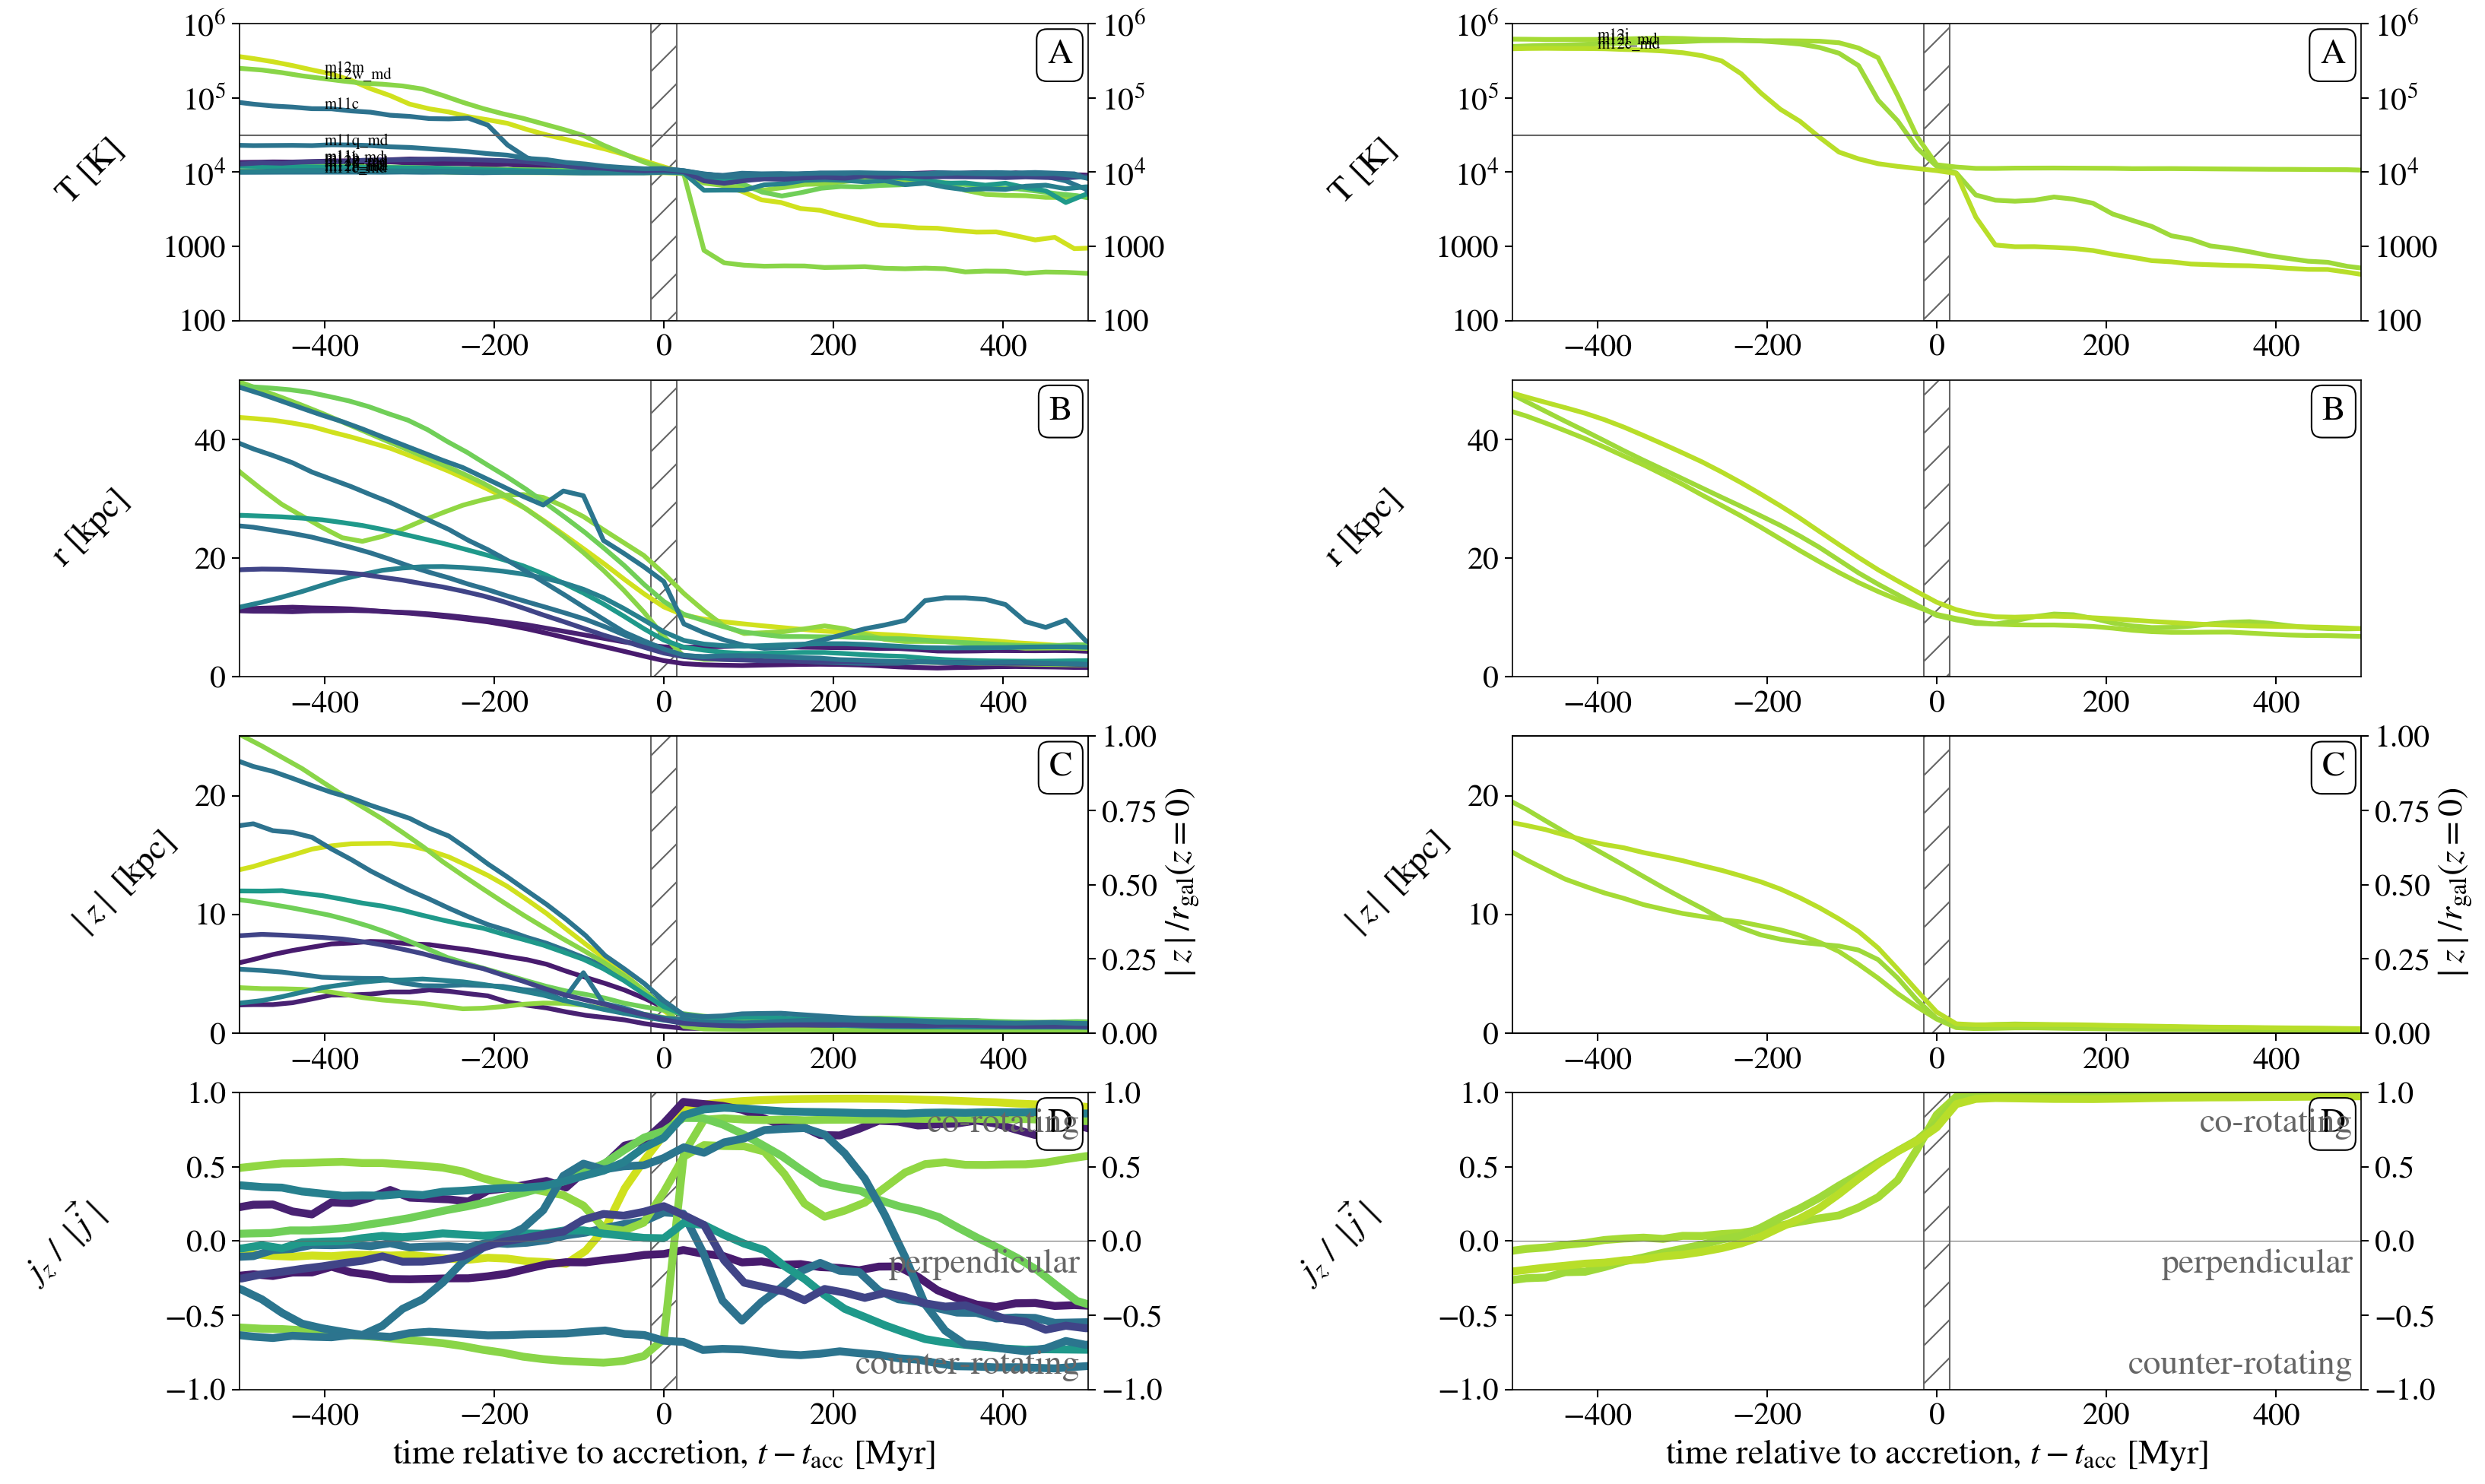

In [87]:
fig